# SET ENVIRONMENT

In [1]:
# allows to import own functions
import sys
import os
import re
root_project = re.findall(r'(^\S*TFM)', os.getcwd())[0]
sys.path.append(root_project)

In [2]:
import pandas as pd
from src.features.add_features import add_features
from src.utils.help_func import rename_indicators
from sklearn.model_selection import  train_test_split, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from yellowbrick.regressor import residuals_plot, prediction_error, PredictionError
from yellowbrick.model_selection import validation_curve, learning_curve, feature_importances
import pickle
from scipy.stats import  loguniform, randint, uniform
import joblib

from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.callbacks import DeltaYStopper

sns.set()

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
seed = 42
df_raw = pd.read_csv("../../data/processed/simulation_results_REV4.csv")
df_raw = df_raw.sample(30000, random_state=seed)
df_raw.head()

,i_country,R0,Tc,Tr,omega,ind_inf_1,ind_inf_2,ind_inf_sumgrad,ind_inf_p,ind_mort_1,ind_mort_2,ind_mort_3,ind_mort_sumgrad,n_closed,react_time,total_infected,total_deceased,total_recovered
46730,NIC,2.726164,2.880362,7.852337,0.333682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,16,13,1.0,0.0,0.0
48393,TTO,15.615708,1.581239,24.692166,0.508220,5.233333,10.139389,23.526981,0.000113,0.783439,4.970197,10.266054,10.5,15,14,359605.0,333040.0,26437.0
41416,SUR,13.349681,1.923908,25.683558,0.438960,2.000000,2.419256,6.085120,0.000104,0.850000,8.045612,8.642644,2.0,18,13,156036370.0,142061448.0,12594398.0
34506,VEN,12.878925,1.575816,20.294810,0.665217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,19,15,1.0,0.0,0.0
43725,TKM,6.054086,2.731820,16.538675,0.678012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,7,1,1.0,0.0,0.0


In [4]:
df = add_features(df_raw)
df = rename_indicators(df)

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df.columns

Index(['i_country', 'R0', 'Tc', 'Tr', 'omega', 'ind_inf_1', 'ind_inf_2',
       'ind_inf_sumgrad', 'ind_inf_p', 'ind_mort_1', 'ind_mort_2',
       'ind_mort_3', 'ind_mort_sumgrad', 'n_closed', 'react_time',
       'total_infected', 'total_deceased', 'total_recovered', 'betweenness',
       'degree', 'closeness', 'country_pop', 'country_departures',
       'exposed_pop', 'total_deceased_log', 'ind_1.3', 'ind_1.4', 'ind_1.1',
       'ind_1.2', 'ind_2.2', 'ind_2.3', 'ind_2.4', 'ind_2.1',
       'betweenness_log', 'degree_log', 'country_pop_log',
       'country_departures_log', 'exposed_pop_log', 'affected_population'],
      dtype='object')

In [6]:
df = df.loc[df['total_deceased'] > 1 ]
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(20204, 39)
(19259, 39)


In [7]:
features = [
    'ind_1.1',
    'ind_1.2',
    'ind_1.3',
    'ind_1.4',
    'ind_2.1',
    'ind_2.2',
    'ind_2.3',
    'ind_2.4',
    'n_closed',
    'react_time',
    'betweenness_log',
    'degree_log',
    'closeness',
    'country_pop_log',
    'country_departures_log',
    'exposed_pop_log',
    'affected_population'
    ]


df = df[features]
df.head()

,ind_1.1,ind_1.2,ind_1.3,ind_1.4,ind_2.1,ind_2.2,ind_2.3,ind_2.4,n_closed,react_time,betweenness_log,degree_log,closeness,country_pop_log,country_departures_log,exposed_pop_log,affected_population
48393,3.158148,-9.088466,1.655048,2.316428,2.351375,-0.244061,1.603460,2.328843,15,14,-5.547479,-2.106841,0.441352,14.144712,6.616065,19.965769,0.000044
41416,1.805846,-9.169503,0.693147,0.883460,0.693147,-0.162519,2.085127,2.156709,18,13,-8.140420,-2.917771,0.385417,13.263847,6.700731,19.249124,0.018858
24656,10.979096,-6.045470,8.352413,9.572624,9.948628,-0.634691,-0.050146,1.791781,4,9,-9.577623,-2.144581,0.393617,17.799080,9.513994,21.921267,0.473662
22411,12.998546,1.544631,9.723803,8.968487,9.553717,-2.093050,-2.184036,-0.079092,2,7,-5.853222,-2.917771,0.388792,11.580369,7.012115,19.616169,0.440854
936,12.068965,-8.469177,9.184157,10.229026,10.572662,-0.906085,-0.595658,1.349568,7,19,-3.484589,-0.574364,0.560606,21.054532,12.924383,22.212935,0.131193


# DATA PREPARATION

In [8]:
X = df.drop('affected_population', axis=1)
y = df['affected_population']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y,
                                                  random_state=seed)

In [9]:
def ResultsRegressorCV(scores):
    print(f"R2: {scores['test_r2'].mean()}, {scores['test_r2'].std()}")
    print(f"MAE: {-scores['test_neg_mean_absolute_error'].mean()}, {scores['test_neg_mean_absolute_error'].std()}")
    print(f"RMSE: {-scores['test_neg_root_mean_squared_error'].mean()}, {scores['test_neg_root_mean_squared_error'].std()}")
    return None

def make_scores(d_score, model_name):
    try:
        df = pd.read_pickle('scores_models.pkl')
        df[model_name] = list(d_score.values())
        df.to_pickle('scores_models.pkl')
    except:
        s = pd.Series(d_score)
        s.name = model_name
        df = pd.DataFrame(s)
        df.to_pickle('scores_models.pkl')

# MODEL

In [10]:
estimator = xgb.XGBRegressor(random_state=seed)

pipe = Pipeline(
    [
        ("estimator", estimator),
    ]
)

In [11]:
score = cross_validate(pipe, X, y, n_jobs=-1, scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'])
ResultsRegressorCV(score)

R2: 0.923163342308807, 0.003052723109947848
MAE: 0.0329092918586876, 0.0005325020357575002
RMSE: 0.0555420940128481, 0.0012615990980998396


In [12]:
make_scores(score, 'XGBoost')

In [13]:
score

{'fit_time': array([1.58998823, 1.57972383, 1.58176923, 1.60623407, 1.57051444]),
 'score_time': array([0.01615405, 0.01576972, 0.01630807, 0.01611876, 0.015517  ]),
 'test_r2': array([0.92297635, 0.91878494, 0.92673433, 0.92100124, 0.92631986]),
 'test_neg_mean_absolute_error': array([-0.03299802, -0.03363809, -0.03241175, -0.03328783, -0.03221077]),
 'test_neg_root_mean_squared_error': array([-0.05539835, -0.05775874, -0.05453853, -0.05585745, -0.0541574 ])}

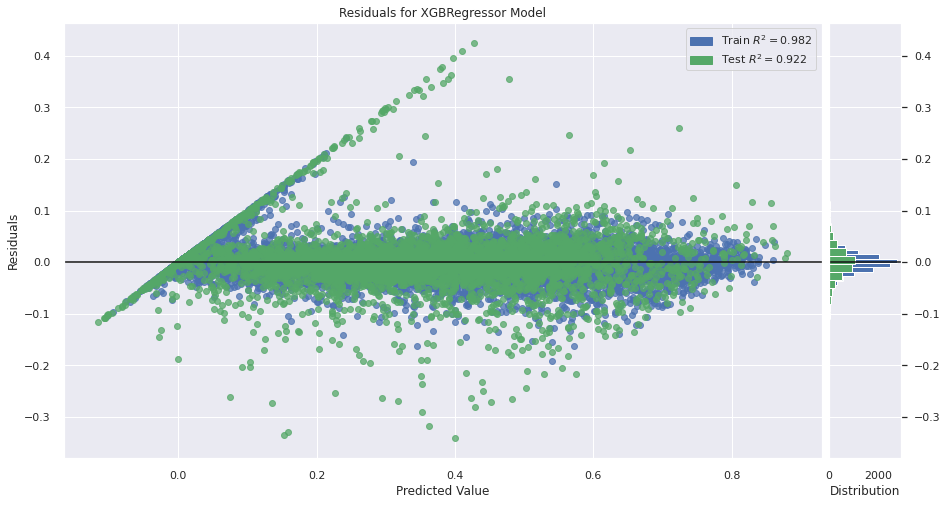

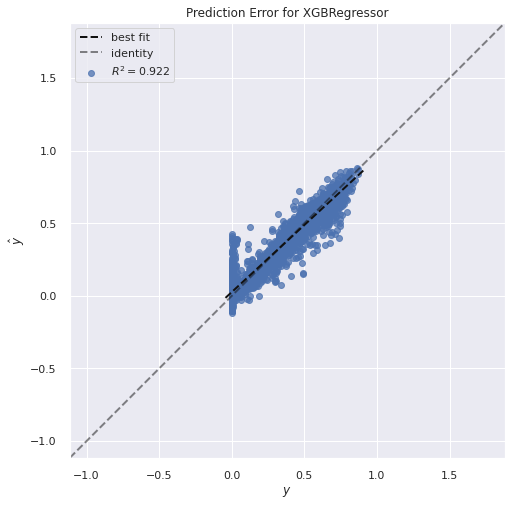

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


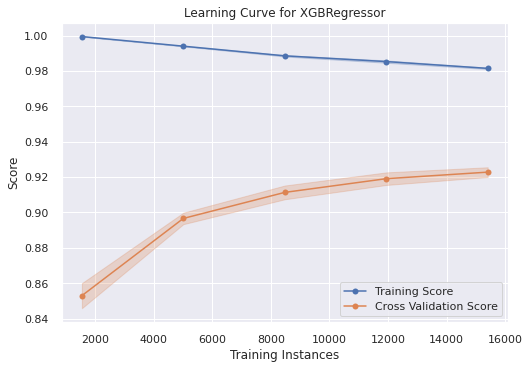

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


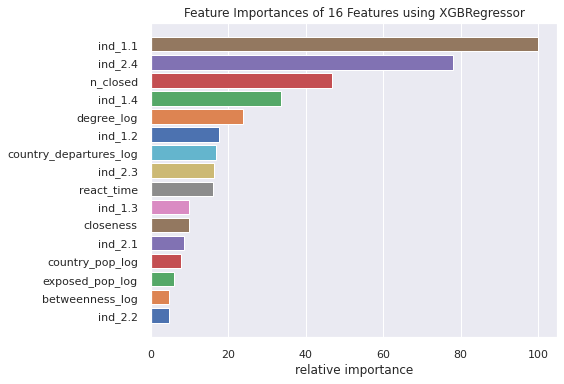

FeatureImportances(ax=<AxesSubplot:title={'center':'Feature Importances of 16 Features using XGBRegressor'}, xlabel='relative importance'>,
                   model=None)

In [14]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
viz = residuals_plot(pipe, X_train, y_train, X_test, y_test, ax=ax)

fig, ax = plt.subplots(1,1, figsize=(15,8))
viz = prediction_error(pipe, X_train, y_train, X_test, y_test, ax=ax)

learning_curve(pipe, X, y, scoring='r2', n_jobs=-1)

feature_importances(estimator, X, y)

# FINE TUNNING

In [15]:
def results_searchcv(
        cv_estimator,
        path=None,
        estimator=None,
        X_test=None,
        y_test=None):

    res_dict = {}
    res_dict['best_score_cross-val'] = cv_estimator.best_score_
    res_dict['std_cross-val'] = cv_estimator.cv_results_['std_test_R2'][cv_estimator.best_index_]
    res_dict['RMSE_cross-val'] = - \
        cv_estimator.cv_results_['mean_test_RMSE'][cv_estimator.best_index_]
    res_dict['MAE_cross-val'] = - \
        cv_estimator.cv_results_['mean_test_MAE'][cv_estimator.best_index_]
    res_dict['best_params'] = cv_estimator.best_params_

    print("=" * 20)
    print(f"Cross-val best score:\n{res_dict['best_score_cross-val']}")
    print(
        f"Cross-val std:\n{res_dict['std_cross-val']}")
    print(f"Cross-val RMSE:\n{res_dict['RMSE_cross-val']}")
    print(f"Cross-val MAE:\n{res_dict['MAE_cross-val']}")
    print(f"Best parameters found:\n{res_dict['best_params']}")
    print("=" * 20)
    
    
def results_searchcv_bayes(
        cv_estimator,
        path=None,
        estimator=None,
        X_test=None,
        y_test=None):

    res_dict = {}
    res_dict['best_score_cross-val'] = cv_estimator.best_score_
    res_dict['std_cross-val'] = cv_estimator.cv_results_['std_test_score'][cv_estimator.best_index_]
    res_dict['best_params'] = cv_estimator.best_params_

    print("=" * 20)
    print(f"Cross-val best score:\n{res_dict['best_score_cross-val']}")
    print(
        f"Cross-val std:\n{res_dict['std_cross-val']}")

    print(f"Best parameters found:\n{res_dict['best_params']}")
    print("=" * 20)

In [16]:
param_dist = {'n_estimators': randint(150, 1000),
              'learning_rate': uniform(0.01, 0.6),
              'subsample': uniform(0.3, 0.9),
              'max_depth': randint(3,10),
              'colsample_bytree': uniform(0.5, 0.9),
              'min_child_weight': randint(1,5)
             }

In [17]:
scoring = {'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error',
           'MAE': 'neg_mean_absolute_error'}

random_search = RandomizedSearchCV(xgb.XGBRegressor(random_state=seed), param_distributions=param_dist,
                                   scoring=scoring,
                                   refit='R2',                                      
                                   verbose=1, n_iter=100, cv=3,
                                   random_state=seed, n_jobs=-1)

# random_search.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.3min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1b2cf7ee80>,
                                        'n_estimators': <s

In [18]:
# joblib.dump(random_search,'models/xgboost_randomsearch.pkl')
random_search = joblib.load('models/xgboost_randomsearch.pkl')

In [19]:
results_searchcv(random_search)

Cross-val best score:
0.9372983135001096
Cross-val std:
0.0022077900990413453
Cross-val RMSE:
0.05018048042361626
Cross-val MAE:
0.02749329614447979
Best parameters found:
{'colsample_bytree': 0.9249934326457544, 'learning_rate': 0.08175654756298101, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 918, 'subsample': 0.9495565690483858}


In [20]:
search_space = dict(
    n_estimators=Integer(150, 1000),
    max_depth=Integer(3, 10),
    learning_rate=Real(0.01, 0.8),
    subsample=Real(0.3, 1),
    colsample_bytree=Real(0.5, 1),
    gamma=Integer(0,5)
)

scores = []
i = 0
def on_step(optim_result, n_last=10):
    """
    Callback meant to view scores after each iteration while performing Bayesian
    Optimization in Skopt. Stops the optimization if the score in the last
    n_last iterations are equal."""
    global i
    i += 1
    scores.append(opt.best_score_)
    print(f"best score: {scores[-1]}")
    if i > n_last and len(set(scores[i-n_last:])) <= 1:
        return True

In [21]:
opt = BayesSearchCV(xgb.XGBRegressor(random_state=seed), search_space, random_state=seed, verbose=1,
                    n_iter=100, n_jobs=-1)

In [22]:
# opt.fit(X, y, callback=on_step)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.0s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best score: 0.6922400886270047
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.1s remaining:   28.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best score: 0.6922400886270047
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.7s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best score: 0.7091732586876701
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.8s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best score: 0.8171080800867797
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   18.4s remaining:   27.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best score: 0.8171080800867797
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.4s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best score: 0.8171080800867797
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.7s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best score: 0.8171080800867797
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best score: 0.8171080800867797
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.5s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished


best score: 0.8171080800867797
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


best score: 0.8171080800867797
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


best score: 0.8171080800867797
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished


best score: 0.8215947889971125
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.9s remaining:   16.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.0s finished


best score: 0.8546502162526449
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.5s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished


best score: 0.8546502162526449
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.2s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


best score: 0.8546502162526449
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.3s remaining:   24.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished


best score: 0.8546502162526449
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.2s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.1s finished


best score: 0.8546502162526449
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.3s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


best score: 0.8546502162526449
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.0s remaining:   49.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.2s finished


best score: 0.8634579167810723
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.7s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished


best score: 0.8634579167810723
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


best score: 0.8634579167810723
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.6s remaining:   29.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished


best score: 0.8634579167810723
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.4s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished


best score: 0.8634579167810723
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   31.9s remaining:   47.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.5s finished


best score: 0.8634579167810723
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.5s remaining:   32.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.6s finished


best score: 0.8634579167810723
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   28.8s remaining:   43.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.8s finished


best score: 0.8634579167810723
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.8s remaining:   20.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.4s finished


best score: 0.8634579167810723
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   30.5s remaining:   45.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.3s finished


best score: 0.8634579167810723


BayesSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None...
                             'gamma': Integer(low=0, high=5, prior='uniform', transform='identity'),
                             'learning_rate': Real(low=0.01, high=0.8, prior='uniform', transform='identity'),
                             'max_depth': Integer(low=3, high=10, prior='uniform', tr

In [23]:
# joblib.dump(opt,'models/xgboost_bayessearch.pkl')
opt = joblib.load('models/xgboost_bayessearch.pkl')

In [24]:
results_searchcv_bayes(opt)

Cross-val best score:
0.8634579167810723
Cross-val std:
0.0038343929851073224
Best parameters found:
OrderedDict([('colsample_bytree', 1.0), ('gamma', 1), ('learning_rate', 0.19430705426820724), ('max_depth', 10), ('n_estimators', 1000), ('subsample', 0.9088527944151519)])


# TEST SET

In [25]:
df_test = pd.read_csv('../../data/processed/simulation_results_REV4_test.csv')
df_test

,i_country,R0,Tc,Tr,omega,ind_inf_1,ind_inf_2,ind_inf_sumgrad,ind_inf_p,ind_mort_1,ind_mort_2,ind_mort_3,ind_mort_sumgrad,n_closed,react_time,total_infected,total_deceased,total_recovered
0,MRT,6.957955,1.712730,11.917101,0.421474,5.200000e+00,8.642633e+00,2.391741e+01,0.000035,0.717949,4.460011,4.170287,9.5,11,20,1.128905e+06,9.414420e+05,1.873230e+05
1,CRI,10.071858,1.993278,20.076016,0.256798,8.853333e+01,2.085479e+02,1.121798e+03,0.000531,0.508660,1.089355,4.263092,240.0,18,16,2.215812e+09,1.856075e+09,3.600110e+08
2,DNK,13.220658,2.176956,28.780786,0.556694,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,9,12,1.000000e+00,0.000000e+00,0.000000e+00
3,GRC,10.596798,0.878435,9.308599,0.953062,4.333333e+00,8.490222e+00,1.022128e+01,0.000012,0.823077,9.969037,7.228118,8.0,10,20,4.477377e+08,4.023809e+08,4.534857e+07
4,FIN,7.026326,2.165711,15.216989,0.433996,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,9,18,1.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,PLW,15.000192,1.136469,17.047250,0.062791,1.058593e+05,9.130263e+04,3.299506e+06,176.353732,0.074554,0.049978,0.621937,118502.5,11,18,5.120920e+09,2.647732e+09,2.473577e+09
7996,GUM,15.249274,1.770462,26.998260,0.327660,9.250000e+01,2.244101e+02,1.052011e+03,0.016740,0.581622,1.391915,7.305558,288.0,13,10,3.000256e+09,2.695716e+09,3.047204e+08
7997,OMN,10.832344,1.294841,14.026168,0.455143,2.284667e+02,7.268619e+02,2.398521e+03,0.001419,0.589145,1.485245,5.108631,876.5,11,9,2.862542e+09,2.474888e+09,3.876690e+08
7998,NCL,13.829648,0.589161,8.147894,0.098775,8.396607e+06,1.930275e+06,1.220615e+08,886.778145,0.261722,0.367218,0.696197,7306416.5,14,7,4.966547e+09,2.214751e+09,2.751913e+09


In [26]:
df_test = add_features(df_test)
df_test = rename_indicators(df_test)

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
df_test = df_test.loc[df_test['total_deceased'] > 1 ]
print(df_test.shape)
df_test.dropna(inplace=True)
print(df_test.shape)

(5436, 39)
(5185, 39)


In [28]:
features = [
    'ind_1.1',
    'ind_1.2',
    'ind_1.3',
    'ind_1.4',
    'ind_2.1',
    'ind_2.2',
    'ind_2.3',
    'ind_2.4',
    'n_closed',
    'react_time',
    'betweenness_log',
    'degree_log',
    'closeness',
    'country_pop_log',
    'country_departures_log',
    'exposed_pop_log',
    'affected_population',
    ]

df_test = df_test[features]
df_test.head()

,ind_1.1,ind_1.2,ind_1.3,ind_1.4,ind_2.1,ind_2.2,ind_2.3,ind_2.4,n_closed,react_time,betweenness_log,degree_log,closeness,country_pop_log,country_departures_log,exposed_pop_log,affected_population
0,3.174607,-10.248013,1.648659,2.156707,2.251292,-0.331357,1.495151,1.427985,11,20,-9.989554,-2.763620,0.402904,15.297869,6.858565,19.156177,0.000125
1,7.022688,-7.540260,4.483379,5.340169,5.480639,-0.675976,0.085586,1.449995,18,16,-8.073405,-2.224624,0.408088,15.424837,7.991931,20.327708,0.246387
3,2.324472,-11.320802,1.466337,2.138915,2.079442,-0.194706,2.299484,1.977979,10,20,-6.129009,-0.971861,0.504545,16.188337,9.990124,20.978504,0.053415
5,17.296856,7.314873,19.338513,11.886407,15.410504,-1.486454,4.059960,-1.224325,0,14,-8.073405,-2.224624,0.408088,15.424837,7.991931,20.327708,0.227000
7,18.732431,8.647402,16.166950,14.393026,16.057403,-1.978746,-1.026244,-1.220580,18,7,-36.043653,-4.709530,0.383420,10.920745,7.980024,19.605983,0.011278


In [33]:
X_test = df_test.drop('affected_population', axis=1)
y_test = df_test['affected_population']

In [34]:
y_pred = random_search.predict(X_test)

In [35]:
r2_score(y_test, y_pred)

0.9476749650279285

In [37]:
mean_absolute_error(y_test, y_pred)

0.0249642721531401

In [39]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.046181177742775636